# Solubility Prediction by Random Forest Algorithem Using RDKit 2D and 3D Descriptors

**The formula is modeling solubility as a linear function of three factors:**

- logP (lipophilicity): Solubility decreases as logP increases (more hydrophobic molecules are less soluble in water).

- Molecular weight (mol_wt): Solubility increases slightly as molecular weight increases.

- Hydrogen bond donors (h_bond_donors): Solubility decreases as the number of hydrogen bond donors increases.

## 1. Create database

In [37]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np

# Generate a list of SMILES (valid and a few invalid)
smiles_list = [
    "CCO", "O=C(O)c1ccccc1OC", "CN1C=NC2=C1C(=O)N(C(=O)N2C)C", 
    "C([C@@H]([C@@H]([C@H](O)CO)O)O)O", "CC(=O)OC1=CC=CC=C1C(=O)O",
    "CC(C)CC1=CC=C(C=C1)O", "C1=CC=C(C=C1)O", "C1CCCCC1", 
    "C1=CC=NC(=C1)N", "C(CO)NC(C)C", "InvalidSMILES123", 
    "C1CCOC1", "C1=CN=C2C(=N1)C=NC=N2", "NaCl", 
    # ... You can add more SMILES. ...
]

# Generate synthetic solubility based on descriptors
data = []
for smiles in smiles_list * 10:  # Repeat to create more entries.
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Calculate descriptors
        logp = Descriptors.MolLogP(mol)
        mol_wt = Descriptors.MolWt(mol)
        h_bond_donors = Descriptors.NumHDonors(mol)
        
        # Simulate solubility: higher solubility for lower logP, lower molecular weight
        solubility = 0.5 - 0.02 * logp + 0.001 * mol_wt - 0.1 * h_bond_donors
        solubility += np.random.normal(0, 0.05)  # Add noise
        
        # Normalize: Clip solubility between 0 and 1
        solubility = np.clip(solubility, 0.05, 0.95)
        data.append({"SMILES": smiles, "Solubility": round(solubility, 2)})

# Create DataFrame and save
df = pd.DataFrame(data)
df.to_csv("sample_solubility_2.csv", index=False)

[17:44:45] SMILES Parse Error: syntax error while parsing: InvalidSMILES123
[17:44:45] SMILES Parse Error: check for mistakes around position 3:
[17:44:45] InvalidSMILES123
[17:44:45] ~~^
[17:44:45] SMILES Parse Error: Failed parsing SMILES 'InvalidSMILES123' for input: 'InvalidSMILES123'
[17:44:45] SMILES Parse Error: syntax error while parsing: NaCl
[17:44:45] SMILES Parse Error: check for mistakes around position 2:
[17:44:45] NaCl
[17:44:45] ~^
[17:44:45] SMILES Parse Error: Failed parsing SMILES 'NaCl' for input: 'NaCl'
[17:44:45] SMILES Parse Error: syntax error while parsing: InvalidSMILES123
[17:44:45] SMILES Parse Error: check for mistakes around position 3:
[17:44:45] InvalidSMILES123
[17:44:45] ~~^
[17:44:45] SMILES Parse Error: Failed parsing SMILES 'InvalidSMILES123' for input: 'InvalidSMILES123'
[17:44:45] SMILES Parse Error: syntax error while parsing: NaCl
[17:44:45] SMILES Parse Error: check for mistakes around position 2:
[17:44:45] NaCl
[17:44:45] ~^
[17:44:45] SMILE

## 2. Prepare the data and calculate descriptions
The amount of features we import in our file has great impact. 
Too much features without PCA leads to overfitting. This is what I saw when I imported 3d data in current code.  

### Do we have outliers?
If the output of the following cell shows many outliers, Robust Scaling is the best choice for normalizing. Otherwise, use Standard Scaling.

In [38]:
# Load the dataset
data = pd.read_csv("molecular_descriptors.csv")

# Exclude non-numeric columns (e.g., SMILES, Solubility)
numeric_data = data.select_dtypes(include=[np.number])

# Detect outliers using IQR
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = ((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).sum()

# Print the number of outliers per column
print(f"the number of outliers per column: {outliers[outliers > 0]}")

the number of outliers per column: MinAbsEStateIndex         10
SPS                       30
MinPartialCharge          10
MaxAbsPartialCharge       10
FpDensityMorgan1          10
                          ..
fr_para_hydroxylation     30
fr_phenol                 20
fr_phenol_noOrthoHbond    20
fr_pyridine               10
Solubility                10
Length: 81, dtype: int64


In [39]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem

# Load the dataset
data = pd.read_csv("sample_solubility_2.csv")

def get_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        desc = Descriptors.CalcMolDescriptors(mol)
        desc["PolarSurfaceArea"] = rdMolDescriptors.CalcTPSA(mol)  # 2D Descriptor

        # Generate 3D Conformer (required for 3D descriptors)
        mol = Chem.AddHs(mol)  # Add hydrogens
        if AllChem.EmbedMolecule(mol, AllChem.ETKDG()) == 0:  # Ensure embedding succeeds
            desc["RadiusOfGyration"] = rdMolDescriptors.CalcRadiusOfGyration(mol)  # 3D Descriptor
            desc["Asphericity"] = rdMolDescriptors.CalcAsphericity(mol)  # 3D Descriptor
            desc["Eccentricity"] = rdMolDescriptors.CalcEccentricity(mol)  # 3D Descriptor
        else:
            desc["RadiusOfGyration"] = None
            desc["Asphericity"] = None
            desc["Eccentricity"] = None

        return desc
    return None

# Apply the function to create a descriptor DataFrame
descriptor_list = []
for idx, row in data.iterrows():
    desc = get_descriptors(row["SMILES"])
    if desc is not None:
        desc["SMILES"] = row["SMILES"]  # Track valid SMILES
        desc["Solubility"] = row["Solubility"]
        descriptor_list.append(desc)

# Create final DataFrame
df = pd.DataFrame(descriptor_list).dropna()
print(f"Valid molecules: {len(df)}")

# Save to CSV
df.to_csv("molecular_descriptors.csv", index=False)
print("Saved descriptors to molecular_descriptors.csv")


Valid molecules: 120
Saved descriptors to molecular_descriptors.csv


## 3. Preprocess    
Main parts:  
1. Split
2. Normalize (if didn't in previous part)  
Had major problams with this part.  


The changes I can make to improve my results:    
- remove ouliers: Didn't work well with my sample.  
- Selecting best features while omitting others to avoid overfitting. I have to recieve the name of selected features.  
- Handle missing values.

In [40]:
# Load your generated descriptor data
df = pd.read_csv("molecular_descriptors.csv")

# Split into features (X) and target (y)
X = df.drop(["SMILES", "Solubility"], axis=1)
y = df["Solubility"]

# Handle missing values (if any)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# Split into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
print(f"X_train = {X_train.shape} , X_test = {X_test.shape}, y_train = {y_train.shape}, y_test = {y_test.shape}")

X_train = (96, 221) , X_test = (24, 221), y_train = (96,), y_test = (24,)


In [42]:
# Normalize the data with RobustScaler as we have outliers.

from sklearn.preprocessing import RobustScaler

# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data (if applicable)
X_test_scaled = scaler.transform(X_test)

# Check the scaling
print(f"X_train_scaled = {X_train_scaled.shape} , X_test_scaled = {X_test_scaled.shape}")

X_train_scaled = (96, 221) , X_test_scaled = (24, 221)


### Feature Selection

In [43]:
from sklearn.decomposition import PCA

#Decreasing the number of features from 221 to the best number of components:
pca = PCA(n_components=17)
pca.fit(X_train_scaled)

X_new_train= pca.transform(X_train_scaled)
X_new_test = pca.transform(X_test_scaled)
#y_new_train = y_train_clean
X_train.shape , X_new_train.shape, #y_new_train.shape
#Check the decrease in features

((96, 221), (96, 17))

Let's learn more about the features our model used.

In [44]:
# Load feature names from molecular_description.csv
file_path = "molecular_descriptors.csv"  
molecular_data = pd.read_csv(file_path)

# Extract feature names from the CSV file
feature_names = molecular_data.columns[:-2].tolist()  # Exclude the last two columns
print("Feature names loaded from CSV:", feature_names)
print("Number of features:", len(feature_names))

Feature names loaded from CSV: ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 

In [45]:
def get_pca_top_features(pca, feature_names, top_n=17):
    """
    Get the top contributing features for each principal component.

    Args:
        pca: The trained PCA object.
        feature_names: List of original feature names.
        top_n: Number of top features to select for each principal component.

    Returns:
        A dictionary where keys are principal components (PC1, PC2, ...) and values are lists of top features.
    """
    # Create a DataFrame for PCA components
    components = pd.DataFrame(
        pca.components_,
        columns=feature_names,
        index=[f"PC{i+1}" for i in range(pca.n_components_)]
    )
    
    # Find the top contributing features for each principal component
    top_features = {}
    for pc in components.index:
        # Get the absolute values of contributions and sort them
        sorted_features = components.loc[pc].abs().sort_values(ascending=False)
        # Select the top N features
        top_features[pc] = sorted_features.head(top_n).index.tolist()
    
    return top_features

# Print the top features for each principal component
top_features = get_pca_top_features(pca, feature_names, top_n=5)

for pc, features in top_features.items():
    print(f"{pc}: {features}")

PC1: ['EState_VSA9', 'EState_VSA1', 'SMR_VSA4', 'SlogP_VSA8', 'PEOE_VSA2']
PC2: ['VSA_EState4', 'SMR_VSA4', 'PEOE_VSA2', 'EState_VSA1', 'EState_VSA10']
PC3: ['VSA_EState4', 'EState_VSA9', 'EState_VSA1', 'SMR_VSA4', 'SlogP_VSA10']
PC4: ['PEOE_VSA14', 'EState_VSA10', 'SlogP_VSA8', 'BCUT2D_MWHI', 'PEOE_VSA11']
PC5: ['SMR_VSA4', 'BCUT2D_MWHI', 'PEOE_VSA14', 'EState_VSA1', 'VSA_EState5']
PC6: ['BCUT2D_MWHI', 'SlogP_VSA8', 'SMR_VSA4', 'SlogP_VSA4', 'BCUT2D_LOGPHI']
PC7: ['PEOE_VSA2', 'SlogP_VSA8', 'SlogP_VSA4', 'EState_VSA8', 'SMR_VSA4']
PC8: ['Kappa3', 'EState_VSA8', 'VSA_EState8', 'Phi', 'EState_VSA9']
PC9: ['EState_VSA4', 'BCUT2D_MWHI', 'VSA_EState8', 'Eccentricity', 'BalabanJ']
PC10: ['SlogP_VSA4', 'EState_VSA1', 'EState_VSA9', 'VSA_EState9', 'BalabanJ']
PC11: ['PEOE_VSA2', 'EState_VSA9', 'BalabanJ', 'FpDensityMorgan1', 'SlogP_VSA4']
PC12: ['Asphericity', 'Eccentricity', 'RadiusOfGyration', 'SlogP_VSA4', 'EState_VSA4']
PC13: ['Eccentricity', 'Asphericity', 'RadiusOfGyration', 'EState_VSA

## 4. Training the model
I used GridSearchCV to optimize the parameters of my randomforest model.

### Save and load the model
Why Save the Model?
- **Consistency**: Saving the model ensures that you can reuse the same trained model without retraining, which avoids variations in results due to randomness.  


- **Efficiency**: Loading a saved model is faster than retraining it every time.

In [46]:
# Load the saved model
best_model = joblib.load("best_model.pkl")
print("Model loaded successfully.")

Model loaded successfully.


### Let's spice up with testing other models!

In [47]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_new_train, y_train)

y_pred_train_lr = model_lr.predict(X_new_train)
y_pred_test_lr = model_lr.predict(X_new_test)

In [48]:
from sklearn.tree import DecisionTreeRegressor

model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_new_train, y_train)

y_pred_train_dt = model_dt.predict(X_new_train)
y_pred_test_dt = model_dt.predict(X_new_test)


In [49]:
from sklearn.neighbors import KNeighborsRegressor

model_knn = KNeighborsRegressor(n_neighbors=8)
model_knn.fit(X_new_train, y_train)

y_pred_train_knn = model_knn.predict(X_new_train)
y_pred_test_knn = model_knn.predict(X_new_test)


In [50]:
from sklearn.ensemble import GradientBoostingRegressor

model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb.fit(X_new_train, y_train)
y_pred_train_gb = model_gb.predict(X_new_train)
y_pred_test_gb = model_gb.predict(X_new_test)

In [51]:
from sklearn.svm import SVR

model_svr = SVR()
model_svr.fit(X_new_train, y_train)
y_pred_train_svr = model_svr.predict(X_new_train)
y_pred_test_svr = model_svr.predict(X_new_test)

### In Case of running into bugs, Check these cells. Oherwise skip them.

In [52]:
#Verify Data Types
print(y_train.dtype)  # Should output `float64` or `int64`
print(y_test.dtype)   # Should not output `object`

float64
float64


In [53]:
print(type(X_train))  # If it's a DataFrame, use .values. If it's an array, skip.

# .values:
#Ensure Input Shapes
# Check that X_train, X_test, y_train, and y_test are NumPy arrays or Pandas DataFrames (not lists or other objects):
# Convert to NumPy arrays if needed
#X_train = X_train.values
#X_test = X_test.values
#y_train = y_train.values.ravel()  # Flatten to 1D array
#y_test = y_test.values.ravel()

<class 'numpy.ndarray'>


## 5. Evaluate

- RMSE (Root Mean Squared Error): Measures the average prediction error (lower = better).  
Example: RMSE = 0.5 means predictions are off by ~0.5 units (e.g., logS) on average.<br>
<br> 

- R² (R-squared): Measures how much variance your model explains (1 = perfect, 0 = no better than the mean). <br>Train R² ≈ Test R² (e.g., Train R² = 0.85, Test R² = 0.80). Test R² ≥ 0.7 is often good.

In [54]:
# Here I define a function to find these metrics easier later.

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Let's define a function that works for testing each regression model.
def calculate_regression_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calculate metrics for training set
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)  # Compute RMSE manually
    #rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    r2_train = r2_score(y_train, y_pred_train)
    
    # Calculate metrics for test set
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)  # Compute RMSE manually
    #rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"Train RMSE: {rmse_train:.2f}, Train R²: {r2_train:.2f}")
    print(f"Test RMSE: {rmse_test:.2f}, Test R²: {r2_test:.2f}")

    return rmse_train, rmse_test, r2_train, r2_test

In [55]:
# Evaluate Random Forest Regressor
print("🔷 Random Forest Regressor")
print("Best Parameters:", grid_search.best_params_)
train_rmse_rf, test_rmse_rf, train_r2_rf, test_r2_rf = calculate_regression_metrics(
    y_train, y_test, y_pred_train_rf, y_pred_test_rf
)

# Evaluate Linear Regression
print("\n🔷 Linear Regression")
train_rmse_lr, test_rmse_lr, train_r2_lr, test_r2_lr = calculate_regression_metrics(
    y_train, y_test, y_pred_train_lr, y_pred_test_lr
)

# Evaluate Decision Tree Regressor
print("\n🔷 Decision Tree Regressor")
train_rmse_dt, test_rmse_dt, train_r2_dt, test_r2_dt = calculate_regression_metrics(
    y_train, y_test, y_pred_train_dt, y_pred_test_dt
)

# Evaluate Gradient Boosting Regressor
print("\n🔷 Gradient Boosting Regressor")
train_rmse_gb, test_rmse_gb, train_r2_gb, test_r2_gb = calculate_regression_metrics(
    y_train, y_test, y_pred_train_gb, y_pred_test_gb
)

# Evaluate Support Vector Regressor
print("\n🔷 Support Vector Regressor")
train_rmse_svr, test_rmse_svr, train_r2_svr, test_r2_svr = calculate_regression_metrics(
    y_train, y_test, y_pred_train_svr, y_pred_test_svr
)

# Evaluate K-Nearest Neighbors Regressor
print("\n🔷 K-Nearest Neighbors Regressor")
train_rmse_knn, test_rmse_knn, train_r2_knn, test_r2_knn = calculate_regression_metrics(
    y_train, y_test, y_pred_train_knn, y_pred_test_knn
)


🔷 Random Forest Regressor
Best Parameters: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Train RMSE: 0.06, Train R²: 0.80
Test RMSE: 0.06, Test R²: 0.63

🔷 Linear Regression
Train RMSE: 0.05, Train R²: 0.86
Test RMSE: 0.06, Test R²: 0.62

🔷 Decision Tree Regressor
Train RMSE: 0.00, Train R²: 1.00
Test RMSE: 0.07, Test R²: 0.44

🔷 Gradient Boosting Regressor
Train RMSE: 0.01, Train R²: 0.99
Test RMSE: 0.06, Test R²: 0.57

🔷 Support Vector Regressor
Train RMSE: 0.05, Train R²: 0.83
Test RMSE: 0.08, Test R²: 0.41

🔷 K-Nearest Neighbors Regressor
Train RMSE: 0.05, Train R²: 0.85
Test RMSE: 0.06, Test R²: 0.61


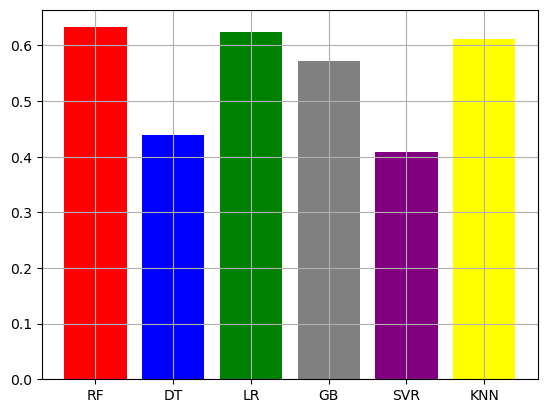

In [56]:
# Compare test R2 on a plot:

import matplotlib.pyplot as plt

r2_test = [test_r2_rf, test_r2_dt, test_r2_lr, test_r2_gb, test_r2_svr, test_r2_knn]

title = ['RF', 'DT', 'LR', 'GB', 'SVR', 'KNN']

colors = ['red', 'blue', 'green', 'gray', 'purple', 'yellow']

plt.bar(title, r2_test, color=colors)
plt.grid()
plt.show()

The Evaluation shows that this model is not efficient enough. It might be due small sample size or inapropriate ML algorithm.

### Let's check a random data

In [ ]:
# Specify the index of the data point you want to check
specific_index = 5  # Replace with the desired index

# Ensure X_test and y_test are NumPy arrays
X_test_array = np.array(X_new_test)  # Convert to NumPy array if it's a DataFrame
y_test_array = np.array(y_test)  # Convert to NumPy array if it's a Series

# Get the data point and its true label
data_point = X_test_array[specific_index].reshape(1, -1)  # Reshape for prediction
real_label = y_test_array[specific_index]

# Predict the label using the model
predicted_label = best_model.predict(data_point)[0]

# Print the results
print(f"Index: {specific_index}")
print(f"Real Label: {real_label}")
print(f"Predicted Label: {predicted_label}")

Index: 5
Real Label: 0.67
Predicted Label: 0.4974493406593403


### You can change the number of PCA components(features) if the model is overfitting.
1. Use the number you recieve as number of PCA components in the following cell in the pca = PCA(n_components=17)
2. Run the model and Evaluate again

In [43]:
# Finding the best number of PCA components(features).
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

best_score = -1
for n in range(5, 21):  # Test PCA components from 5 to 20
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_scaled)
    scores = cross_val_score(model, X_train_pca, y_train, cv=5, scoring='r2')
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_n = n

print(f"Best number of PCA components: {best_n}")

Best number of PCA components: 19
